In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:

from tensorboard import program

log_dir = "D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs"
tb=program.TensorBoard()
tb.configure(argv=[None, '--logdir', log_dir])
url = tb.launch() #  lanza TensorBoard en el navegador



In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8917071741278190253
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3640655872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7723826916492919053
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [8]:
import os
import psutil

def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f'Memory usage: {process.memory_info().rss / 1024 ** 2} MB')

print_memory_usage()

Memory usage: 836.703125 MB


In [3]:
#TENSORFLOW SIN GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Esto fuerza a TensorFlow a usar la CPU

import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funciones_ML as bt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,classification_report,r2_score,RocCurveDisplay,confusion_matrix, accuracy_score,recall_score,f1_score,precision_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
#import category_encoders as ce
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import regularizers
from sklearn.compose import ColumnTransformer
from tensorflow.keras.losses import CategoricalCrossentropy, sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint





# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Código para los tamaños de las fuentes y los "ticks" de los ejes:
plt.rc('font', size=6)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


In [5]:
df_rn=pd.read_csv(r"D:\Cursos\REPOSITORIOS\DATASET\malware_total\df_malware_fin_ML_origen.csv")

In [6]:
df_rn.shape

(15181640, 116)

In [6]:
X=df_rn.drop(["Target"], axis=1)
y=df_rn["Target"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12145312, 115)
(3036328, 115)
(12145312,)
(3036328,)


In [8]:
# Convertir los datos a float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [9]:
# Convertir los datos a arrays de NumPy
X_train_a = X_train.values
X_test_a = X_test.values
y_train_a = y_train.values
y_test_a = y_test.values


In [8]:
X_train_a.shape

(12145312, 115)

1. MODELO NEURONAL SECUANCIAL
    - el modelo se compone de 4 capas bidimensionales de entrada junto a 4 capas densas en sentido decreciente y alternando activaciones relu y elu, que impiden la muerte neuronal. Despues de la concatenacion de las capas, el modelo continua con 4 capas densas con la mismas caracteristicas que las anteriores, a excepcion de la capa de entrada, que llega un regularizador l2 para controlar el sobreajuste y detras de cada capa densa hay una capa batchnormalization que mejora la tasa de aprendizaje, evitando el sobreajuste y ayudando a la regularizacion, fiinalizando con unca capa de salida de 2 unidades yu activacion sotfmax para clasificacion.
    Al modelo le acompaña un early_stopping, para evitar el sobreajuste si se repite 5 veces el mismo valor y un reduce_lr, el cual reduce la tasa de aprendizaje cuando el conjunto de validacion no mejora

## MODELOS SECUENCIALES SIN GPU CON DESBALANCEO DE LA TARGET

MODELO ADAM

In [11]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=32, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=16, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=8, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # sigmoide para clasificacion binaria
#optimizador
optimizador=Adam( learning_rate=0.01, # rebajo el learning rate por ser mas adecuado para un ajuste fino aunque tarde mas
                    beta_1=0.6, # influye en el gradiente pasado (1 mas al gradiente y 0 nada)
                    beta_2=0.4, #influye en los cuadrados de los gradientes pasados(1 mas a la varianza y 0 nada)
                    epsilon=1e-09, #es para prevenior divisiones entre 0
                    amsgrad=False)#es una variante de Adam y ayuda con la convergencia de ambos a evitar oscilaciones de los pesos durante la optimizacion"""
# Compilar el modelo
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)
#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)
#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [early_stopping_callbacks, reduce_lr_callbacks, checkpoint_callbacks, tensorboard_callback]
# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=32, epochs=10,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
341564/341587 [============================>.] - ETA: 0s - loss: 0.4302 - accuracy: 0.8021 - precision: 0.7369 - recall: 0.9896
Epoch 1: val_loss improved from inf to 0.43033, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo.h5
341587/341587 [==============================] - 725s 2ms/step - loss: 0.4302 - accuracy: 0.8021 - precision: 0.7369 - recall: 0.9896 - val_loss: 0.4303 - val_accuracy: 0.8031 - val_precision: 0.7349 - val_recall: 0.9977 - lr: 0.0010
Epoch 2/10
341578/341587 [============================>.] - ETA: 0s - loss: 0.4249 - accuracy: 0.8033 - precision: 0.7376 - recall: 0.9910
Epoch 2: val_loss did not improve from 0.43033
341587/341587 [==============================] - 665s 2ms/step - loss: 0.4249 - accuracy: 0.8033 - precision: 0.7376 - recall: 0.9910 - val_loss: 0.4443 - val_accuracy: 0.8035 - val_precision: 0.7396 - val_recall: 0.9857 - lr: 0.0010
Epoch 3/10
341585/341587 [============================>.] - ETA: 0s - loss: 0.4245 

In [16]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                7424      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)               

In [20]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_test_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_test_a, y_pred_classes))

94886/94886 [==============================] - 93s 976us/step - loss: 0.4293 - accuracy: 0.8039 - precision: 0.7359 - recall: 0.9977
Loss: 0.4293183386325836
Accuracy: 0.8039270043373108
precision: 0.7358649373054504
recall: 0.9977438449859619
94886/94886 [==============================] - 62s 650us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63   1384396
         1.0       0.00      0.00      0.00   1651932

    accuracy                           0.46   3036328
   macro avg       0.23      0.50      0.31   3036328
weighted avg       0.21      0.46      0.29   3036328



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 .  Los resultados indican que el modelo tiene un buen desempeño en la clasificación en la clase Malicius (sensibilidad alta), pero tiene un desempeño más bajo en la clasificación de la    clase 0 (precisión baja):
    -   Loss: relativamente bajo para las predicciones del modeelos respecto a las etiquetas correctas.
    -   Accuracy: el modelo clasifico correctamente im 80.39 % del conjunto de datos, lo cual es bueno.
    -   Precision.- la precision es de un 70.39, es decir de cada 10 positvos clasifica como verdaderos positivos 7.36 casos.
    -   sensibilidad.- la capacidad del modelos de discernir entre clases es de un 99.77%, es decir que los positvos detectados pertenecen a la calse 0(mayoritaria)
    -   f1-score.- que es una medida qwue combina precision y sensibilidad, es de un 85.02%, existiend un buen equilibrio entre ambas


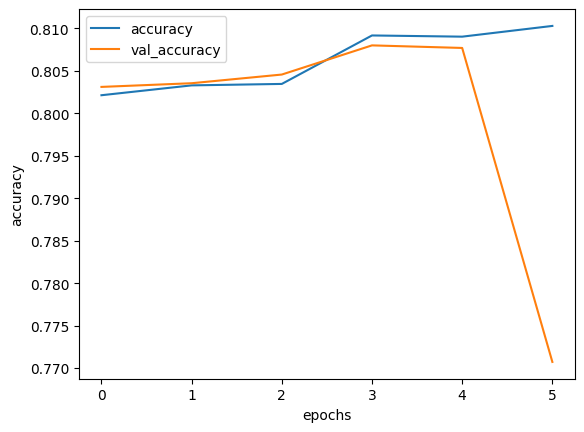

In [13]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

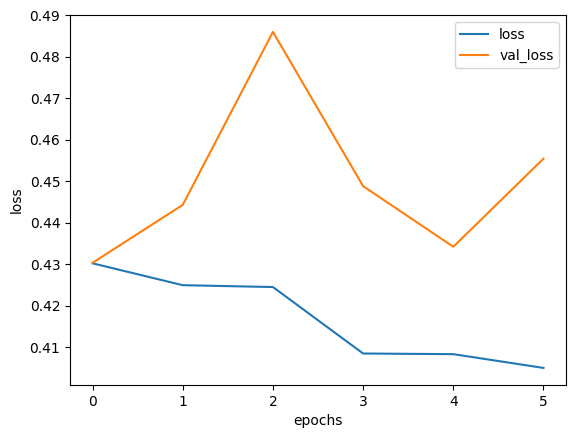

In [14]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

MODELO CON SGD


In [12]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=64, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=64, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=64, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # sigmoide para clasificacion binaria
#optimizador
optimizador= tf.keras.optimizers.SGD(learning_rate=0.005,
                                      momentum=0.9, #aporta inercia al proceso de optimizacion, acelerando la convergencia
                                      nesterov=True)# en True actualiza momentum demanera anticipada al gradiente, mejorando la estaboiilidad

# Compilar el modelo
modelo.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [reduce_lr_callbacks, early_stopping_callbacks, checkpoint_callbacks]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=64, epochs=10,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
170785/170794 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.7988 - precision: 0.7362 - recall: 0.9820
Epoch 1: val_loss improved from inf to 0.42515, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
170794/170794 [==============================] - 331s 2ms/step - loss: 0.4513 - accuracy: 0.7988 - precision: 0.7362 - recall: 0.9820 - val_loss: 0.4251 - val_accuracy: 0.7968 - val_precision: 0.7280 - val_recall: 0.9999 - lr: 0.0100
Epoch 2/10
170770/170794 [============================>.] - ETA: 0s - loss: 0.4246 - accuracy: 0.8012 - precision: 0.7371 - recall: 0.9864
Epoch 2: val_loss improved from 0.42515 to 0.41982, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
170794/170794 [==============================] - 322s 2ms/step - loss: 0.4246 - accuracy: 0.8012 - precision: 0.7371 - recall: 0.9864 - val_loss: 0.4198 - val_accuracy: 0.8026 - val_precision: 0.7338 - val_recall: 0.9994 - lr: 0

In [13]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                7424      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [14]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_test_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_test_a, y_pred_classes))

94886/94886 [==============================] - 95s 997us/step - loss: 0.4060 - accuracy: 0.8064 - precision: 0.7384 - recall: 0.9974
Loss: 0.40602222084999084
Accuracy: 0.8063921332359314
precision: 0.7384393215179443
recall: 0.9974405765533447
94886/94886 [==============================] - 74s 777us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63   1384396
         1.0       0.00      0.00      0.00   1651932

    accuracy                           0.46   3036328
   macro avg       0.23      0.50      0.31   3036328
weighted avg       0.21      0.46      0.29   3036328



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


valores similares ante anteriores modelo con Adams y uso de distintas unidades, sigue ganando la calse mayoritariam por lo que vamos avolver a repetir estas reds haciendo previante un ressempled

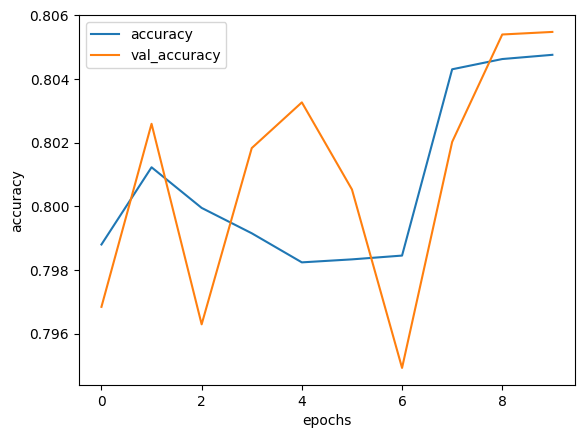

In [15]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

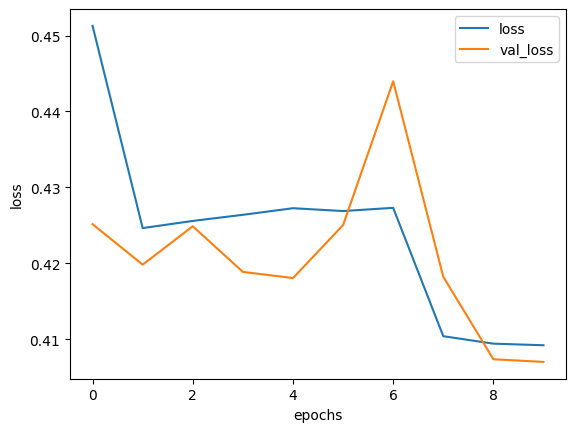

In [16]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

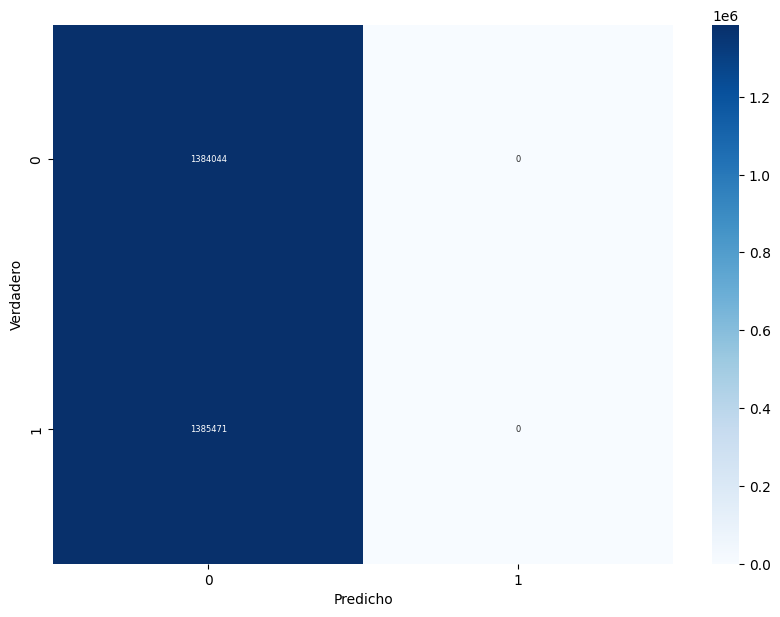

In [44]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()

## APLICAMOS RESAMPLED A LA CLASE MINORITARIA

In [18]:
# Aplica submuestro, para reducir el número de observaciones de todas las clases menos la clase minoritaria
X=df_rn.drop(["Target"], axis=1)
y=df_rn["Target"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11078059, 115)
(2769515, 115)
(11078059,)
(2769515,)


<Axes: xlabel='Target', ylabel='Count'>

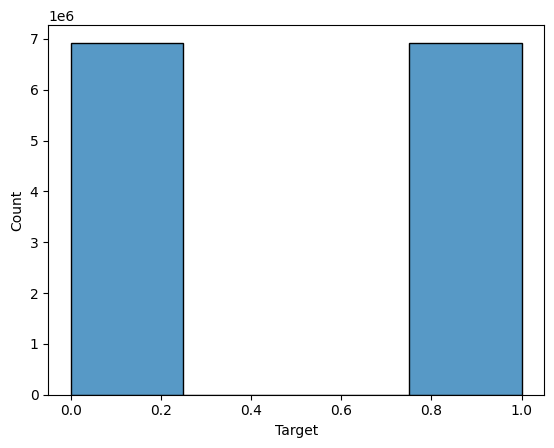

In [22]:
sns.histplot(y_resampled, bins=4)

In [31]:
# Convertir los datos a float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

In [32]:
X_train_a=X_train.values
y_train_a=y_train.values
X_test_a=X_test.values
y_test_a=y_test.values

## MODELOS SECUENCIALES BALANCEADOS Y SIN GPU

MODELO CON ADAM

In [25]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=32, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=16, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=8, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # sigmoide para clasificacion binaria
#optimizador
optimizador=Adam( learning_rate=0.01, # rebajo el learning rate por ser mas adecuado para un ajuste fino aunque tarde mas
                    beta_1=0.6, # influye en el gradiente pasado (1 mas al gradiente y 0 nada)
                    beta_2=0.4, #influye en los cuadrados de los gradientes pasados(1 mas a la varianza y 0 nada)
                    epsilon=1e-09, #es para prevenior divisiones entre 0
                    amsgrad=False)#es una variante de Adam y ayuda con la convergencia de ambos a evitar oscilaciones de los pesos durante la optimizacion"""

# Compilar el modelo
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_adam_resampled.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [early_stopping_callbacks, reduce_lr_callbacks, checkpoint_callbacks, tensorboard_callback]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=32, epochs=10,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
311545/311571 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.7837 - precision: 0.7024 - recall: 0.9844
Epoch 1: val_loss improved from inf to 0.43760, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_adam_resampled.h5
311571/311571 [==============================] - 671s 2ms/step - loss: 0.4389 - accuracy: 0.7837 - precision: 0.7024 - recall: 0.9844 - val_loss: 0.4376 - val_accuracy: 0.7835 - val_precision: 0.7071 - val_recall: 0.9675 - lr: 0.0010
Epoch 2/10
311555/311571 [============================>.] - ETA: 0s - loss: 0.4322 - accuracy: 0.7857 - precision: 0.7032 - recall: 0.9884
Epoch 2: val_loss did not improve from 0.43760
311571/311571 [==============================] - 621s 2ms/step - loss: 0.4322 - accuracy: 0.7857 - precision: 0.7032 - recall: 0.9884 - val_loss: 0.4390 - val_accuracy: 0.7862 - val_precision: 0.7050 - val_recall: 0.9839 - lr: 0.0010
Epoch 3/10
311571/311571 [==============================] - ETA: 0s 

In [26]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                7424      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)               

In [33]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_test_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_test_a, y_pred_classes))

86548/86548 [==============================] - 82s 944us/step - loss: 0.4370 - accuracy: 0.7846 - precision: 0.7084 - recall: 0.9676
Loss: 0.43704232573509216
Accuracy: 0.7845828533172607
precision: 0.7084441184997559
recall: 0.9675958752632141
86548/86548 [==============================] - 63s 731us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67   1384044
         1.0       0.00      0.00      0.00   1385471

    accuracy                           0.50   2769515
   macro avg       0.25      0.50      0.33   2769515
weighted avg       0.25      0.50      0.33   2769515



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


sIGUE PREDICIENDO PARA LA CLASE MALICIOUS, HABIENDO MEJORADO UNOS PUNTOS LA PRECISISION, HABIENDO MEJORADO TAMBIEN LA TSA F1-, ASI QUE EN RESUMEN Los resultados indican que el modelo tiene un buen desempeño en la identificación de la clase 0 (SENSIBILIDAD alta), pero tiene un desempeño muy bajo en la identificación de ejemplos de la clase 1 (precisión baja)

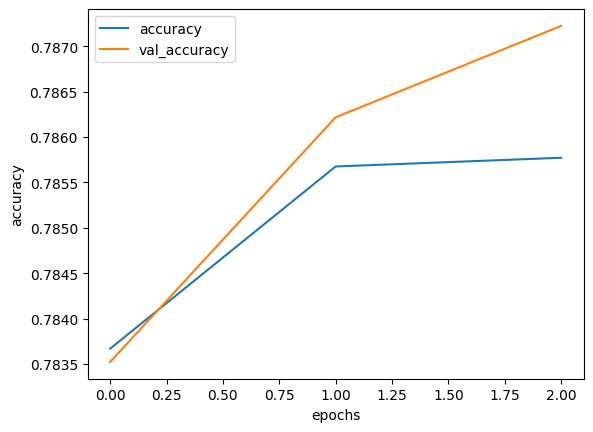

In [34]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

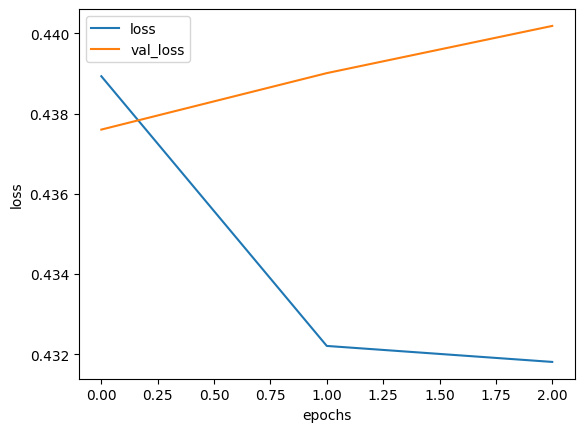

In [35]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

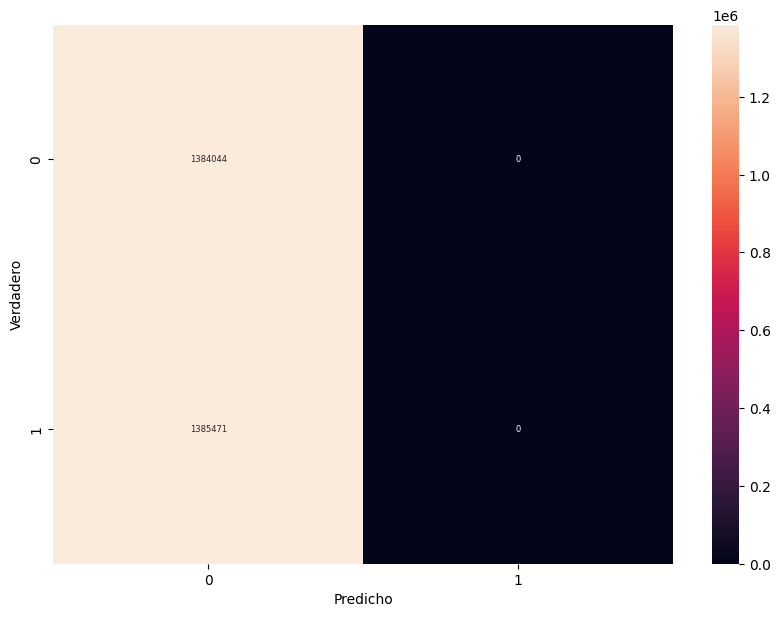

In [39]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()

MODELO CON SGD

In [45]:
odelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=64, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=64, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=64, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # sigmoide para clasificacion binaria
#optimizador
optimizador= tf.keras.optimizers.SGD(learning_rate=0.005,
                                      momentum=0.9, #aporta inercia al proceso de optimizacion, acelerando la convergencia
                                      nesterov=True)# en True actualiza momentum demanera anticipada al gradiente, mejorando la estaboiilidad

# Compilar el modelo
modelo.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [reduce_lr_callbacks, early_stopping_callbacks, checkpoint_callbacks]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=64, epochs=10,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
155772/155786 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.7727 - precision: 0.6944 - recall: 0.9740
Epoch 1: val_loss improved from inf to 0.53436, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
155786/155786 [==============================] - 442s 3ms/step - loss: 0.4572 - accuracy: 0.7727 - precision: 0.6944 - recall: 0.9740 - val_loss: 0.5344 - val_accuracy: 0.5847 - val_precision: 0.9735 - val_recall: 0.1735 - lr: 0.0100
Epoch 2/10
155781/155786 [============================>.] - ETA: 0s - loss: 0.4415 - accuracy: 0.7771 - precision: 0.6985 - recall: 0.9751
Epoch 2: val_loss improved from 0.53436 to 0.45404, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
155786/155786 [==============================] - 444s 3ms/step - loss: 0.4415 - accuracy: 0.7771 - precision: 0.6985 - recall: 0.9751 - val_loss: 0.4540 - val_accuracy: 0.7836 - val_precision: 0.6999 - val_recall: 0.9924 - lr: 0

In [46]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_test_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_test_a, y_pred_classes))

86548/86548 [==============================] - 102s 1ms/step - loss: 0.4349 - accuracy: 0.7821 - precision: 0.6966 - recall: 1.0000
Loss: 0.4349230229854584
Accuracy: 0.7821384072303772
precision: 0.6966235637664795
recall: 0.9999942183494568
86548/86548 [==============================] - 76s 882us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67   1384044
         1.0       0.00      0.00      0.00   1385471

    accuracy                           0.50   2769515
   macro avg       0.25      0.50      0.33   2769515
weighted avg       0.25      0.50      0.33   2769515



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


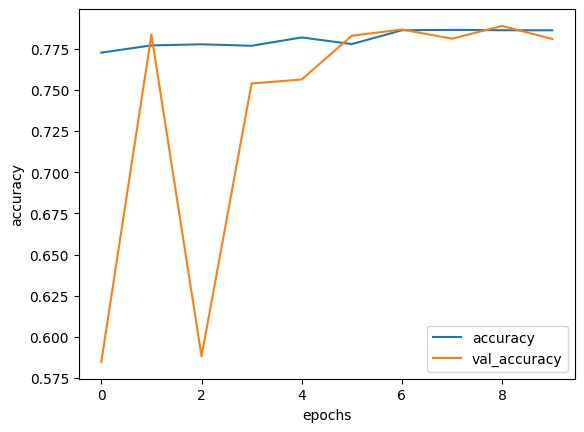

In [47]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

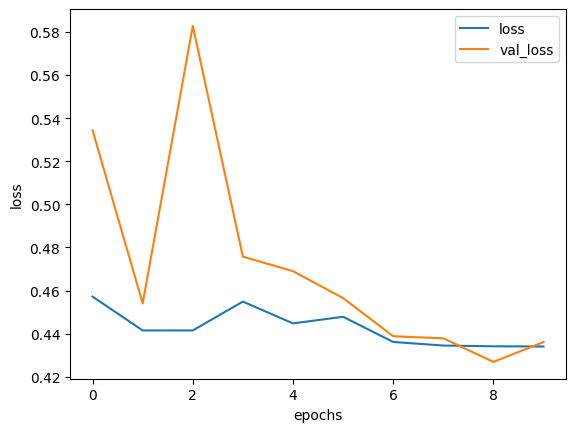

In [48]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

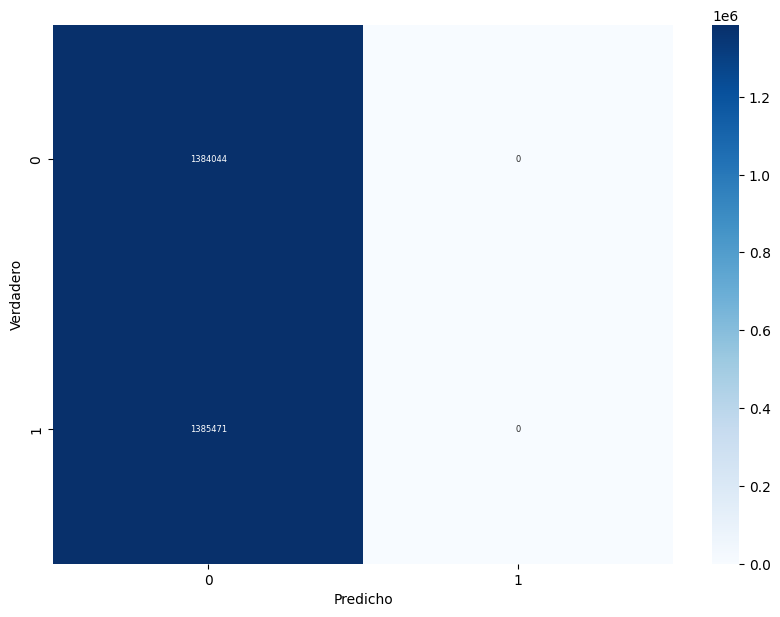

In [50]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()